# Model

This file contains all the code necessary to build  and train the first stage pose estimation model as described in Figure 1b of [Hands Deep in Deep Learning](https://arxiv.org/pdf/1502.06807v2.pdf), but does not yet implement the hand pose prior constraint.

In [ ]:
from keras.models import Sequential, model_from_yaml, load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.layers import *
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
import scipy.misc
import math
import random
import h5py
from os import path

### Loading dataset

The default dataset location is the dataset/ subfolder of the project root.
The [.hdf5](http://www.h5py.org/) file produced by [data.ipynb](data#Output-dataset) is placed in this directory after processing.

In [ ]:
DATASET_DIR      = 'dataset'
dataset          = h5py.File(path.join(DATASET_DIR, 'dataset.hdf5'))

test_images      = dataset['image/test']
test_labels      = dataset['label/test']
test_centers     = dataset['center/test']

train_images     = dataset['image/train']
train_labels     = dataset['label/train']
train_centers    = dataset['center/train']

pca_eigenvectors = dataset['pca/eigenvectors'][:30]
pca_mean         = dataset['pca/mean']

In [ ]:
# Resize an image to the specified dimensions, scaling its label accordingly
def resize(image, label, dimensions):
    scale        = np.array(dimensions) / image.shape[:-1]
    label[::3]  *= scale[1]
    label[1::3] *= scale[0]
    
    # TODO: Try to implement or use OpenCV's INTER_AREA resize strategy?
    image = scipy.misc.imresize(np.squeeze(image), dimensions, 'bilinear', mode='F')
    
    return image, label

In [ ]:
# Clip an image to the specified bounding box, translating its label accordingly
# Bounding box should look like np.array([[x_1, y_1], [x_2, y_2]]), where
# (x_1, y_1) are the coordinates of the lower left corner and 
# (x_2, y_2) are the coordinates of the upper right corner
def clip(image, label, bounding_box):
    label[::3]  -= bounding_box[0, 1]
    label[1::3] -= bounding_box[0, 0]
    
    image_box = np.array([[0, 0], image.shape[:-1]], dtype='int')
    
    padding = np.array([image_box[0] - bounding_box[0], bounding_box[1] - image_box[1]]).clip(0)
    bounding_box += padding[0]
    padding = np.concatenate((padding.T, np.array([[0, 0]])))
    
    image = np.pad(image, padding, 'edge')
    image = image[slice(*bounding_box[:, 0]), slice(*bounding_box[:, 1])]
    
    return image, label

In [ ]:
def augment(image, label, scale_range=np.zeros(3), translate_range=np.zeros(3)):
    image = image.copy()
    label = label.copy()
    
    scale = 1 + (np.random.random(3) - 0.5) * scale_range
    translate = (np.random.random(3) - 0.5) * translate_range
    
    bounds = np.array([[0, 0], [1, 1]], dtype='float')
    bounds -= 0.5
    bounds *= image.shape[:-1]
    bounds /= scale[:-1]
    bounds += 64
    bounds -= translate[:-1]
    bounds = bounds.astype(int)
    
    image, label = clip(image, label, bounds)
    image[image != 1] /= scale[-1]
    image[image != 1] += translate[-1]
    label[2::3] /= scale[-1]
    label[2::3] += translate[-1]
    image = np.clip(image, -1, 1)
    
    image, label = resize(image, label, (128, 128))
    image = np.expand_dims(image, 2)
    
    return image, label

In [ ]:
def augment_batch(image_batch, label_batch, scale_range=np.zeros(3), translate_range=np.zeros(3)):
    image_batch, label_batch = zip(*[augment(image, label, scale_range, translate_range) \
                                     for image, label in zip(image_batch, label_batch)])
    
    return np.array(image_batch), np.array(label_batch)

In [ ]:
def generate_batches(images, labels, batch_size):
    while True:
        batch_indices = [(i, min(i + batch_size, len(labels))) for i in range(0, len(labels), batch_size)]
        random.shuffle(batch_indices)
        for start, end in batch_indices:
            image_batch, label_batch = images[start:end], labels[start:end]
            yield image_batch, label_batch

In [32]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

### Network layers

This network is very similar to that implemented in the [Deep Hand Pose](https://github.com/jsupancic/deep_hand_pose/blob/master/examples/deep_hand_pose/oberweger-pca.prototxt) project.

In [ ]:
model = Sequential([
        Convolution2D(
            nb_filter   = 12,
            nb_row      = 5,
            nb_col      = 5,
            subsample   = (2, 2),
            input_shape = (128, 128, 1)
        ),
        LeakyReLU(
            alpha       = 0.05
        ),
        Convolution2D(
            nb_filter   = 12,
            nb_row      = 5,
            nb_col      = 5,
            subsample   = (2, 2),
        ),
        LeakyReLU(
            alpha       = 0.05
        ),
        Convolution2D(
            nb_filter   = 12,
            nb_row      = 5,
            nb_col      = 5,
        ),
        LeakyReLU(
            alpha       = 0.05
        ),
        Flatten(),
        Dense(
            output_dim  = 1024,
            activation  = 'relu'
        ),
        Dense(
            output_dim  = 1024,
            activation  = 'relu'
        ),
        Dense(
            output_dim  = 30,
        ),
        Dense(
            output_dim  = 42,
            weights     = (pca_eigenvectors, pca_mean),
            trainable   = False
        )
    ])

### Optimizer

We use the Adam optimizer, which adaptively modifies the learning rate.

In [ ]:
model.compile(
    optimizer = Adam(),
    loss      = 'mse'
)

In [ ]:
train_data = generate_batches(train_images, train_labels, 64)
test_data  = generate_batches(test_images, test_labels, 64)

In [ ]:
augmented_train_data = (augment_batch(image_batch, label_batch, (0.2, 0.2, 0.2), (32, 32, 0.6)) \
                        for image_batch, label_batch in train_data)

### Training

Similarly to the Deep Hand Pose project, we train on batches of [64 images and labels](https://github.com/jsupancic/deep_hand_pose/blob/master/examples/deep_hand_pose/oberweger-pca.prototxt#L14).

In [ ]:
model.fit_generator(
    augmented_train_data,
    validation_data   = test_data,
    samples_per_epoch = len(train_labels),
    nb_val_samples    = len(test_labels),
    nb_epoch          = 100,
    callbacks         = [
        TensorBoard(),
        ModelCheckpoint(
            filepath       = 'model.hdf5',
            save_best_only = True
        )
    ])

### Evaluation

We evaluate the model on the training set with a batch size of 64, measuring the Euclidean loss.

In [ ]:
model.evaluate(
    test_images,
    test_labels,
    batch_size = 64
)

In [236]:
predictions = model.predict(
    test_images,
    batch_size = 64
)

In [237]:
def uvd_to_xyz(uvd):
    normalized_x = uvd[..., 0] / 640 - 0.5
    normalized_y = 0.5 - uvd[..., 1] / 480
    
    xyz = np.zeros(uvd.shape)
    xyz[..., 2] = uvd[..., 2]
    xyz[..., 0] = normalized_x * xyz[..., 2] * 1.08836710
    xyz[..., 1] = normalized_y * xyz[..., 2] * 0.817612648
    
    return xyz

In [238]:
def denormalize(label, center):
    label = label.copy()
    
    bounds = np.array([[0, 0], [1, 1]], dtype='float')
    bounds = bounds[None, ...].repeat(len(label), 0)
    bounds -= 0.5
    bounds *= 38
    bounds *= 525 / center[..., -1, None, None]
    bounds += center[..., None, -2::-1]
    bounds = bounds.astype(int)
    
    label[..., 0:2] /= (128, 128) / (bounds[..., None, 1, :] - bounds[..., None, 0, :])
    label[..., -1] *= 15.0
    label[..., -1] += center[..., -1, None]
    
    label[..., 0:2] += bounds[..., None, 0, :]
    
    label[..., -1] *= 10
    
    return label

In [239]:
def threshold(actual, predicted, threshold):
    max_distance = np.sqrt(np.sum((actual - predicted) ** 2, -1)).max(-1)
    count = np.sum((max_distance[..., None] < threshold), axis=0)
    return count / len(max_distance)

In [240]:
error = threshold(
    uvd_to_xyz(denormalize(test_labels[:].reshape(-1, 14, 3), test_centers[:])),
    uvd_to_xyz(denormalize(predictions.reshape(-1, 14, 3), test_centers[:])),
    np.linspace(0, 80, 1000)
)

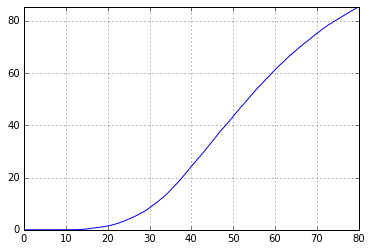

In [241]:
plt.yticks(np.arange(0, 100, 20))
plt.grid()
plt.plot(np.linspace(0, 80, 1000), error * 100)